Name: Avani Gupta <br>
Roll: 2019121004

In [1]:
from os import walk
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms


from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

import glob


In [2]:
dataset_dir = 'images_evaluation/'


In [3]:
classes = os.listdir(dataset_dir)

In [4]:
categories = {}
for c in classes:
    class_chars = os.listdir(os.path.join(dataset_dir,c))
    
    categories[c] = class_chars
    

In [5]:
class SiameseData(Dataset):
    def __init__(self,categories_dic, dataset_dir, num_imgs):
        self.categories_dic = categories_dic
        self.categories_lis = list(categories_dic.keys())
        self.dataset_dir = dataset_dir
        self.num_imgs = num_imgs
        self.transform =  transforms.Compose([transforms.ToTensor()])
        
    def __getitem__(self,idx):
        if idx %2==0: #same category for both imgs
            label = 1.0
            cate = random.choice(self.categories_lis)
            char = random.choice(self.categories_dic[cate])
            imgs_lis = os.listdir(os.path.join(os.path.join(dataset_dir, cate),char))
            img_path = os.path.join(os.path.join(dataset_dir, cate),char)
            img1 , img2 = plt.imread(os.path.join(img_path,random.choice(imgs_lis))), plt.imread(os.path.join(img_path,random.choice(imgs_lis)))
        
        else: # diff category
            label = 0.0
            categories_lis = self.categories_lis.copy()
            cate = random.choice(self.categories_lis)
            char = random.choice(self.categories_dic[cate])
            imgs_lis = os.listdir(os.path.join(os.path.join(dataset_dir, cate),char))
            
            img_path = os.path.join(os.path.join(dataset_dir, cate),char)
            img1 = plt.imread(os.path.join(img_path,random.choice(imgs_lis)))
            
            categories_lis.remove(cate) #so that random.choice doesnt select same category again
            # get img 2 from different category
            cate = random.choice(categories_lis)
            char = random.choice(self.categories_dic[cate])
            imgs_lis = os.listdir(os.path.join(os.path.join(dataset_dir, cate),char))
            img_path = os.path.join(os.path.join(dataset_dir, cate),char)
            img2 = plt.imread(os.path.join(img_path,random.choice(imgs_lis)))
          
        return self.transform(img1), self.transform(img2), torch.tensor([label])
            
    def __len__(self):
        return self.num_imgs
            


train_set =  SiameseData(categories,dataset_dir,5000)  
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, num_workers=8)

val_set =  SiameseData(categories,dataset_dir,500)         
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, num_workers=1, shuffle=True)


In [6]:
class Net(nn.Module):
    '''
    I followed acrhitecture given in paper by Koch et al.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.convs = nn.Sequential(
                        nn.Conv2d(1, 64, 10),
                        nn.BatchNorm2d(64),
                        nn.ReLU(),
                        nn.MaxPool2d(2,stride=2),

                        nn.Conv2d(64, 128, 7),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.MaxPool2d(2,stride=2),

                        nn.Conv2d(128, 128, 4),
                        nn.BatchNorm2d(128),
                        nn.ReLU(),
                        nn.MaxPool2d(2,stride=2),

                        nn.Conv2d(128, 256, 4),
                        nn.BatchNorm2d(256),
                        nn.ReLU(),     
            )
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1)
        
        
    def forward(self, x1, x2):
        x1 = self.convs(x1)
        x1 = x1.view(-1, 256 * 6 * 6)
        x1 = self.sigmoid(self.fc1(x1))
        
        x2 = self.convs(x2)
        x2 = x2.view(-1, 256 * 6 * 6)
        x2 = self.sigmoid(self.fc1(x2))

        x = torch.abs(x1 - x2)
        x = self.fc2(x)
        return x

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Net()
model = model.to(device)
model

Net(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (sigmoid): Sigmoid()
  (fc1): Linear(in_feat

## Training using Siamese network

In [8]:
num_epochs = 50
checkpoint_freq = 25

checkpoint_dir = 'checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

optimizer = optim.Adam(model.parameters(), lr = 0.0006)
criterion = nn.BCEWithLogitsLoss()

val_loss_min = 1e10
val_ep_min = -1
train_loss_lis = []
val_loss_lis = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for img1, img2, labels in train_loader:
        preds = model(img1.to(device), img2.to(device))
        loss = criterion(preds, labels.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    
        
    val_running_loss = 0.0
    with torch.no_grad():
        model.eval()
        for img1, img2, labels in val_loader:
            preds = model(img1.to(device), img2.to(device))
            loss = criterion(preds, labels.to(device))
            val_running_loss += loss.item()
            
    train_loss = running_loss / len(train_loader)  
    train_loss_lis.append(train_loss)
    
    val_loss = val_running_loss / len(val_loader)
    val_loss_lis.append(val_loss)
    
    print(f"Epoch {epoch+1} | train loss: {train_loss} | val loss: {val_loss}")

    if val_loss < val_loss_min:
        val_ep_min, val_loss_min = epoch, val_loss
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "siamese_best.ckpt"))
            
    if epoch % checkpoint_freq == 0:
        torch.save(
                model.state_dict(),
                os.path.join(checkpoint_dir,f"checkpoint_{epoch}.ckpt")
            )
        


    if val_loss > val_loss_min and epoch - val_ep_min > 5: 
        print("early stopping at epoch",epoch)
        break
    

print("Finished Training")  
    
    
    
    
    

Epoch 1 | train loss: 0.5438430070877075 | val loss: 0.4213331569125876
Epoch 2 | train loss: 0.45336746945977213 | val loss: 0.4089429953298531
Epoch 3 | train loss: 0.3820145957171917 | val loss: 0.3579189153526095
Epoch 4 | train loss: 0.3592333659529686 | val loss: 0.32324041921060415
Epoch 5 | train loss: 0.32962066791951655 | val loss: 0.2770953490920947
Epoch 6 | train loss: 0.33772982470691204 | val loss: 0.34273145249571096
Epoch 7 | train loss: 0.32099839076399805 | val loss: 0.32106073555673353
Epoch 8 | train loss: 0.31246535405516623 | val loss: 0.2616293653585635
Epoch 9 | train loss: 0.298033545166254 | val loss: 0.29953998286102435
Epoch 10 | train loss: 0.3018169550225139 | val loss: 0.25932341381104196
Epoch 11 | train loss: 0.2731388498097658 | val loss: 0.26000241880117575
Epoch 12 | train loss: 0.2644831039011478 | val loss: 0.21381356082808747
Epoch 13 | train loss: 0.2630589008331299 | val loss: 0.24915187626468469
Epoch 14 | train loss: 0.24907676540315152 | val

Text(0, 0.5, 'loss')

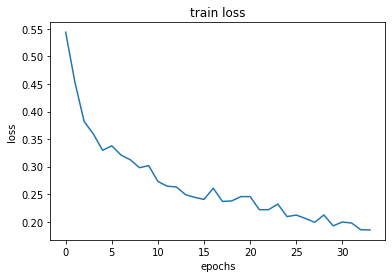

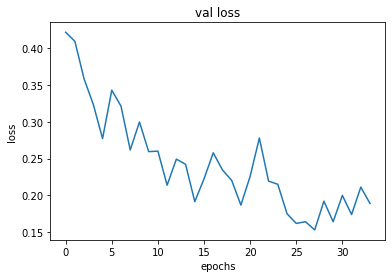

In [15]:
plt.title("train loss")
plt.plot(train_loss_lis)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.figure()

plt.title("val loss")
plt.plot(val_loss_lis)
plt.xlabel("epochs")
plt.ylabel("loss")

In [10]:
# loading saved model
model = Net().to(device)
PATH = 'checkpoints/siamese_best.ckpt'
model.load_state_dict(torch.load(PATH))
model.eval()


Net(
  (convs): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
  )
  (sigmoid): Sigmoid()
  (fc1): Linear(in_feat

## Testing using N-way one shot learning
In an N-way one shot learning, we compare a test image with N different images and select that image which has highest similarity with the test image as the prediction

In [12]:
class NWayOneShot(Dataset):
    def __init__(self, categories_dic, dataset_dir, num_imgs, numWay):
        self.categories_dic = categories_dic
        self.categories_lis = list(categories_dic.keys())
        self.dataset_dir = dataset_dir
        self.num_imgs = num_imgs
        self.transform =  transforms.Compose([transforms.ToTensor()])
        self.numWay = numWay
        
    
    def __getitem__(self, idx):
        cate = random.choice(self.categories_lis)
        char = random.choice(self.categories_dic[cate])
        imgs_lis = os.listdir(os.path.join(os.path.join(dataset_dir, cate),char))
        img_path = os.path.join(os.path.join(dataset_dir, cate),char)
        main_img = self.transform(plt.imread(os.path.join(img_path,random.choice(imgs_lis))))
        
        
        same_class_img = self.transform(plt.imread(os.path.join(img_path,random.choice(imgs_lis))))
        label = random.choice(np.arange(self.numWay))
        categories_lis = self.categories_lis.copy()
        categories_lis.remove(cate) #so that random.choice doesnt select same category again
        imgs = []
        for i in range(self.numWay):
            cate = random.choice(categories_lis)
            char = random.choice(self.categories_dic[cate])
            imgs_lis = os.listdir(os.path.join(os.path.join(dataset_dir, cate),char))
            img_path = os.path.join(os.path.join(dataset_dir, cate),char)
            img = self.transform(plt.imread(os.path.join(img_path,random.choice(imgs_lis))))
            imgs.append(img)
        imgs[label] = same_class_img
     
        return main_img, imgs, torch.tensor([label],dtype=int)
    
    def __len__(self):
        return self.num_imgs



In [16]:
testSize = 5000
numWay = 4
test_set = NWayOneShot(categories, dataset_dir, testSize,numWay=4) 
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 1, num_workers = 2)
# evaluate 
correct = 0
count = 0
for main_img, imgs, label in test_loader:
    similarities = []
    for i, img_test in enumerate(imgs):
        #model gives output(similarity) for each img, the img_test which has highest predicted similarity is chosen
        similarities.append(model(main_img.to(device),  img_test.to(device)).item())
    
    pred = np.argmax(similarities)
            
    if pred == label.item():
        correct = correct+1
    count += 1

print('Accuracy on n way: {}'.format(correct/count))



Accuracy on n way: 0.9452


Convergence at 33rd epoch, accuracy on 4-way testing 0.94, training and val loss graphs are shown above in notebook.




Architecture:
![alt text](archi.png "Title")

The double convolutional design that was previously revealed is the most important aspect of the Siamese Network. As seen in Figure, the first convolutional architecture design is from Koch et al publication "Siamese Neural Networks for One-shot Image Recognition." 
Note that after flattening, the absolute differences between the two convolutional branches(rather than simply one image's input) are sent into the fully-connected layer.
